# CS3244 Project Neural Networks

This file will contain the code for the neural network model that is being used for our project. In this code, we will be approaching it using a two types of models:

1. MLP
2. RNN (LSTM)

We will follow this breakdown of sequencing in how we approach the problem using neural networks.

## Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

### Importing packages

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### Importing datasets

#### MLP datasets

In [16]:
train_df = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/processed_data/transformed_data/train_set.csv')
test_df = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/processed_data/transformed_data/test_set.csv')

In [17]:
X_train = train_df.drop(columns=['fraud_status'])
y_train = train_df['fraud_status']

X_test = test_df.drop(columns=['fraud_status'])
y_test = test_df['fraud_status']

#### RNN datasets

In [3]:
invoice = pd.read_csv('cleaned_invoice_train.csv')
client = pd.read_csv('cleaned_client_train.csv')

## MLP model

The MLP model is a simple feed-forward neural network model. It will use the universally used aggregated dataset that we have used for all other models. We have decided to use an MLP model as it is the best neural network model when it comes to working with our aggregated dataset. This is because RNNs work with sequential data, which the aggregated dataset does not have, and CNN works best for matrix data (images), which again we do not have.

We will proceed with this flow:
1. Feature engineering for MLP
2. Model MLP
3. Evaluate MLP

### Feature Engineering for MLP

We will begin with feature engineering that is specific to the MLP model. This is because neural networks require specific altercations to the data for it to function effectively.

In [32]:
X_train.columns

Index(['district', 'client_id', 'client_catg', 'region', 'creation_date',
       'creation_year', 'creation_month', 'creation_day',
       'consumption_level_1_mean', 'consumption_level_1_std',
       ...
       'meter_coefficient_40', 'meter_coefficient_50', 'reading_remark_6',
       'reading_remark_7', 'reading_remark_8', 'reading_remark_9',
       'meter_type_0', 'meter_type_1', 'is_index_discrepancy_False',
       'is_index_discrepancy_True'],
      dtype='object', length=104)

Columns like client_id, meter_number, and meter_code are identifiers and do not contain useful information for prediction. Drop these columns from the training data.

In [58]:
irrelevant_columns = ['client_id', 'meter_number', 'meter_code', 'creation_date']
X_train = X_train.drop(columns=irrelevant_columns, errors='ignore')
X_test = X_test.drop(columns=irrelevant_columns, errors='ignore')

In [59]:
categorical_columns = ['district', 'client_catg', 'region', 'reading_remark_6', 'reading_remark_7', 
                       'reading_remark_8', 'reading_remark_9', 'meter_type_0', 'meter_type_1', 
                       'is_index_discrepancy_False', 'is_index_discrepancy_True']

numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [41]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

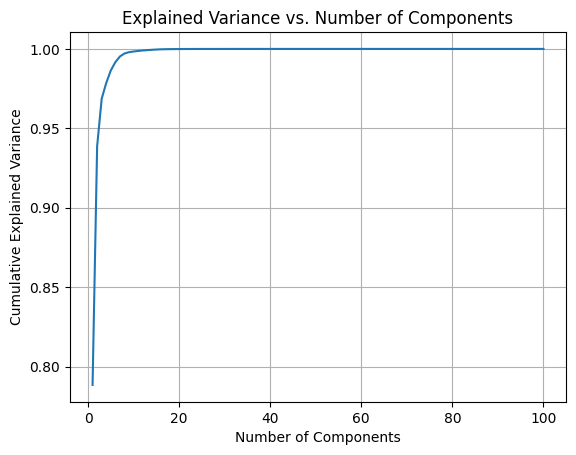

In [48]:
pca = PCA()
pca.fit(X_train)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Plotting the cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Choosing the number of components that explain at least 95% of variance
n_components = next(i for i, cum_var in enumerate(explained_variance_ratio) if cum_var >= 0.95) + 1

In [49]:
pca = PCA(n_components=n_components)  # Choose the number of components based on explained varianc

In [50]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', pca)
    ]
)

In [60]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

### Training MLP model

We will train the neural network on our feature engineered train dataset. Our hyperparameters will be kept fixed (for now), and we will be using the scikit-learn inbuilt function. This is because we were having problems with tensorflow and its compatibility with pandas.

In [68]:
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50), # Two hidden layers with 100 and 50 neurons
    activation='relu',            # Activation function
    solver='adam',                # Optimization algorithm
    max_iter=200,                 
    random_state=42               
)

In [69]:
mlp.fit(X_train_processed, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42)

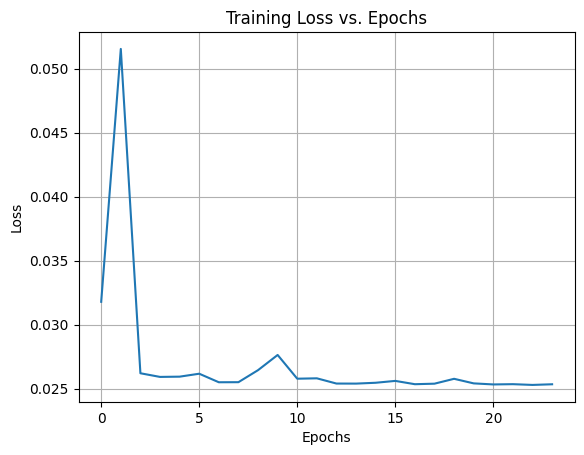

In [70]:
plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid()
plt.show()

### Test MLP model

We will test our model on the feature engineered test dataset. We will be using accuracy, precision, recall, F1 score, as well as a confusion matrix for evaluation.

In [71]:
y_pred = mlp.predict(X_test_processed)
fraud_confidence = (y_pred * 100).clip(0, 100)  # Assuming predictions are in range [0, 1]
fraud_classification = ['Fraud' if confidence > 75 else 'Not Fraud' for confidence in fraud_confidence]

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error

y_pred_class = [1 if confidence > 50 else 0 for confidence in fraud_confidence]
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, pos_label=1)
recall = recall_score(y_test, y_pred_class, pos_label=1)
f1 = f1_score(y_test, y_pred_class, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_pred_class)

In [73]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Accuracy: 0.94
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[25533     2]
 [ 1564     0]]
Mean Squared Error: 0.052687995147509166


## RNN model

We understand that one of the limitations of the MLP model is that it does not take into account each individual invoice of a client. This results in the loss of some information regarding the sequential nature of the invoices. Hence, for the RNN model, we plan to approach this with a non-aggregated dataset. We will follow the same data cleaning as the previous dataset, but without the aggregation and SMOTE. We will then use an RNN with weight class adjustments in order to deal with the imbalanced data.

We will proceed with this flow:
1. Feature engineering for RNN
2. Preparing data for RNN
3. Model RNN
4. Evaluate RNN


### Feature engineering for RNN

The RNN model uses very different feature engineering techniques compared to the MLP model, and hence we need to handle them very differerntly. We will be looking at client first before invoice.

In [4]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456063 entries, 0 to 4456062
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   client_id            object 
 1   invoice_date         object 
 2   meter_number         int64  
 3   meter_status         float64
 4   meter_code           int64  
 5   reading_remark       int64  
 6   meter_coefficient    int64  
 7   consumption_level_1  int64  
 8   consumption_level_2  int64  
 9   consumption_level_3  int64  
 10  consumption_level_4  int64  
 11  old_index            int64  
 12  new_index            int64  
 13  months_number        int64  
 14  meter_type           int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 510.0+ MB


In [5]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   fraud_status   135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


#### Client

Here, we will deal with the client dataset. 

##### creation_date breakdown

We breakdown creation_date into year, month, and day in order for our model to be able to process this feature, as it will not be able to process an object or a datetime datatype.

In [6]:
client['creation_date'] = pd.to_datetime(client['creation_date'])
client['creation_date_year'] = client['creation_date'].dt.year
client['creation_date_month'] = client['creation_date'].dt.month
client['creation_date_day'] = client['creation_date'].dt.day

/var/folders/tq/mlzr5gb55h9flpj2ql8zgd9w0000gn/T/ipykernel_4147/1433498131.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  client['creation_date'] = pd.to_datetime(client['creation_date'])


##### Drop creation_date

We will drop creation_date as we already have its derived features of year month and day.

In [7]:
client = client.drop(columns=['creation_date'])

##### One hot encoding

We will one hot encode our non ordinal categorical features. This is because we do not want our model to assume ordinality or an order in these features, hence we have to one hot encode.

In [8]:
non_ordinal_categorical_client = ['disrict', 'client_catg', 
                                  'region']

client = pd.get_dummies(client, columns=non_ordinal_categorical_client)

##### Label encoding

We will label the features which are categorical but have an order to them. This is to reduce the number of features we will have, and for the model to potentially learn from their ordinal nature.

In [9]:
ordinal_categorical_client = ['creation_date_year', 'creation_date_month', 'creation_date_day']

for col in ordinal_categorical_client:
    counts = client[col].value_counts()
    print(counts)

creation_date_year
2010    6275
2008    5672
2009    5644
2011    5492
2013    5291
2007    5265
2014    5230
2012    5148
2016    4869
2015    4731
2017    4420
2002    4406
2018    3973
2000    3783
2006    3482
2003    3206
2004    2926
1999    2715
1995    2705
1994    2685
1998    2591
2005    2590
2001    2578
1997    2561
1996    2297
1989    2290
1983    2272
1988    2268
1985    2225
1990    2214
1993    2195
1991    2182
1986    2063
1987    1995
1992    1966
1984    1918
1980    1850
1981    1843
1979    1724
1982    1685
1977    1658
1978    1510
2019    1100
Name: count, dtype: int64
creation_date_month
12    20249
11    14039
10    13525
5     12726
9     12240
6     11087
3     10389
4      9992
2      8538
8      7893
7      7840
1      6975
Name: count, dtype: int64
creation_date_day
30    6405
29    5589
28    5471
31    5244
16    5000
21    4953
22    4857
27    4816
26    4774
19    4737
24    4699
13    4591
20    4540
14    4532
23    4519
18    4500
17    4490
7

##### final client

We will now be able to look at the final client dataset.

In [10]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            135493 non-null  object 
 1   fraud_status         135493 non-null  float64
 2   creation_date_year   135493 non-null  int32  
 3   creation_date_month  135493 non-null  int32  
 4   creation_date_day    135493 non-null  int32  
 5   disrict_60           135493 non-null  bool   
 6   disrict_62           135493 non-null  bool   
 7   disrict_63           135493 non-null  bool   
 8   disrict_69           135493 non-null  bool   
 9   client_catg_11       135493 non-null  bool   
 10  client_catg_12       135493 non-null  bool   
 11  client_catg_51       135493 non-null  bool   
 12  region_101           135493 non-null  bool   
 13  region_103           135493 non-null  bool   
 14  region_104           135493 non-null  bool   
 15  region_105       

#### Invoice

Here, we will deal with the invoice dataset.

##### Deal with invoice_date

We will convert invoice_date to the datetime format for easier processing later down the line, as this will be the determining sequential feature that we will use for the RNN modelling.

In [11]:
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

##### Scaling 

We will scale continuous variables, to ensure that all features contribute equally when it comes to the gradient descent during optimization.

In [12]:
continuous_features_invoice = ['consumption_level_1', 'consumption_level_2',
                       'consumption_level_3', 'consumption_level_4',
                        'new_index', 'old_index']

scaler = StandardScaler()
invoice[continuous_features_invoice] = scaler.fit_transform(invoice[continuous_features_invoice])
invoice[continuous_features_invoice]

,consumption_level_1,consumption_level_2,consumption_level_3,consumption_level_4,new_index,old_index
0,-0.437548,-0.090741,-0.129241,-0.06057,-0.097110,-0.086091
1,1.043370,0.062232,-0.129241,-0.06057,-0.114333,-0.135789
2,-0.383239,-0.090741,-0.129241,-0.06057,-0.088254,-0.078122
3,-0.411056,-0.090741,-0.129241,-0.06057,-0.085766,-0.075077
4,0.211513,-0.090741,-0.129241,-0.06057,-0.066518,-0.067182
...,...,...,...,...,...,...
4456058,-0.016321,0.021495,-0.129241,-0.06057,-0.356971,-0.360941
4456059,-0.281244,-0.085752,-0.129241,-0.06057,-0.351945,-0.347700
4456060,-0.203091,-0.090741,-0.129241,-0.06057,-0.102989,-0.096437
4456061,0.252576,-0.090741,-0.129241,-0.06057,-0.109308,-0.111361


##### One hot encoding

We will similarly one hot encode the non ordinal categorical features in invoice for the same reasons as we did for client.

In [13]:
non_ordinal_categorical_invoice = [ 'meter_status', 'meter_code', 
                            'reading_remark', 'meter_type',
                            'meter_coefficient']

invoice = pd.get_dummies(invoice, columns=non_ordinal_categorical_invoice)

##### Label encoding

We will similarly label encode the ordinal categorical features in invoice for the same reasons we did for client.

In [14]:
ordinal_categorical_invoice = ['meter_number', 'months_number']

for col in ordinal_categorical_invoice:
    counts = invoice[col].value_counts()
    print(counts)

meter_number
0          40753
2786         251
630317       230
162709       226
963          219
           ...  
230413         1
5210           1
59752          1
7008124        1
7805975        1
Name: count, Length: 200384, dtype: int64
months_number
4         3679248
8          278497
2          253497
1          112896
12          54204
           ...   
39927           1
53227           1
69016           1
72210           1
463554          1
Name: count, Length: 1349, dtype: int64


##### final invoice

We will now be able to look at the final invoice dataset.

In [15]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456063 entries, 0 to 4456062
Data columns (total 73 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   meter_number          int64         
 3   consumption_level_1   float64       
 4   consumption_level_2   float64       
 5   consumption_level_3   float64       
 6   consumption_level_4   float64       
 7   old_index             float64       
 8   new_index             float64       
 9   months_number         int64         
 10  meter_status_0.0      bool          
 11  meter_status_1.0      bool          
 12  meter_status_2.0      bool          
 13  meter_status_3.0      bool          
 14  meter_status_4.0      bool          
 15  meter_code_5          bool          
 16  meter_code_10         bool          
 17  meter_code_16         bool          
 18  meter_code_25         bool          
 19  

### Preparing data for RNN

In order to prepare our dataset for RNN, we will need to firstly group our invoices by clients, in order of invoice date. We will then be able to extract their informational features. We also need to extract, for the client, their client data, as well as label data (fraud or not fraud). This is so that our RNN is able to use the sequential nature of invoices.

#### Get informational columns

We will obtain the informational features of both invoice and clients, which as the features that we want our model to learn from.

In [16]:
# Invoice feature columns
invoice_feature_cols = invoice.columns.difference(['client_id', 'invoice_date'])

# Client feature columns
client_feature_cols = client.columns.difference(['client_id', 'fraud_status'])

In [17]:
len(invoice_feature_cols)

71

In [18]:
len(client_feature_cols)

35

#### Sort the dataset

We will sort our dataset by client_id and invoice_date, followed by grouping invoices by client_id. This helps us obtain the sequences of of invoices that the RNN will input.

In [19]:
invoice = invoice.sort_values(by=['client_id', 'invoice_date'])
grouped_invoices = invoice.groupby('client_id')

#### Obtain max_length

We need to obtain the max_length of each group (max number of invoices per client), as only then are we able to apply padding to our sequences to ensure that they are all of the same length.

In [20]:
max_length = grouped_invoices.size().max()

#### Create containers

We will create 3 containers to store the features and targets.

In [21]:
invoice_features = []
client_features = []
targets = []


#### iterate each client

For each client, we will select informational invoice features, pad them, and add them to invoice features, then obtain their informational client features and add them to client features, followed by adding their target to the targets container.

In [22]:
for client_id, group in grouped_invoices:
    # Extract and pad invoice features dynamically
    invoices_seq = group[invoice_feature_cols].values  # Select relevant columns
    padded_invoices = np.zeros((max_length, invoices_seq.shape[1]))
    padded_invoices[:len(invoices_seq)] = invoices_seq
    invoice_features.append(padded_invoices)
    
    # Extract client features dynamically
    client_row = client[client['client_id'] == client_id].iloc[0]
    client_feat = client_row[client_feature_cols].values
    client_feat = client_feat.astype(int)
    client_features.append(client_feat)
    
    # Append target
    targets.append(client_row['fraud_status'])

#### Pytorch dataset

We will create a custom pytorch dataset to wrap the data.

In [23]:
class FraudDataset(Dataset):
    def __init__(self, invoice_features, client_features, targets):
        self.invoice_features = torch.tensor(invoice_features, dtype=torch.float32)
        self.client_features = torch.tensor(client_features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'invoices': self.invoice_features[idx],
            'clients': self.client_features[idx],
            'target': self.targets[idx]
        }

: 

In [ ]:
client_features = np.array(client_features).astype(float)
invoice_features = np.array(invoice_features).astype(float)
targets = np.array(targets).astype(float)

In [47]:
print(client_features.dtype)
print(invoice_features.dtype)
print(targets.dtype)

dtype('float64')

In [26]:
train_dataset = FraudDataset(np.array(invoice_features), np.array(client_features), np.array(targets))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

### Training RNN model

Training the RNN model with pyTorch would require us to define a FraudRNN class. We will then set a method for forward, as well as define hyperparameters, which it will take in as input.

#### Create FraudRNN class

We will create the FraudRNN class.

In [ ]:
class FraudRNN(nn.Module):
    def __init__(self, seq_input_dim, client_input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(FraudRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=seq_input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.client_dense = nn.Linear(client_input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_seq, x_client):
        _, (h_n, _) = self.lstm(x_seq)
        lstm_out = h_n[-1]
        client_out = torch.relu(self.client_dense(x_client))
        combined = torch.cat((lstm_out, client_out), dim=1)
        output = self.sigmoid(self.fc(combined))
        return output

#### Create model, criterion and optimizer.

We will then create our model with fixed hyperparameters, while setting a criterion for the loss function and an optimizer for efficient gradient upadtes.

In [ ]:
# Hyperparameters
seq_input_dim = np.array(invoice_features).shape[2]
client_input_dim = np.array(client_features).shape[1]
hidden_dim = 64
output_dim = 1
num_epochs = 10
learning_rate = 0.001
model = FraudRNN(seq_input_dim, client_input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Training loop

Here, we will loop the training so that the model can update its weights to reduce loss.

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_seq_batch, X_client_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_seq_batch, X_client_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

### Test RNN model


We will test our model on the feature engineered RNN test dataset. We will be using accuracy, precision, recall, F1 score, as well as a confusion matrix for evaluation.